In [1]:
import numpy as np
import math
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import cartopy
import cartopy.crs as ccrs
import metpy.calc as mpcalc
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import pop_tools 
import matplotlib.path as mpath
import dask
import esmlab
import utils

### Look at transect from 30°S to 60°S along 180°W

In [2]:
case = 'g.e22.G1850ECO_JRA_HR.TL319_t13.004'
path = '/glade/campaign/cesm/development/bgcwg/projects/hi-res_JRA/cases/' + case + '/output/ocn/proc/tseries/month_1'
variables = ['coccoC','spC','diatC','SiO3','Fe','NO3'] # ,'TEMP','SSH','O2','ALK','SALT','NO3']
coords = {'x':'TLONG','y':'TLAT'}
keep_vars = variables + list(coords.values())+['dz','KMT']

### get 2 three year periods 

In [3]:
def preprocess(ds):
    ds=ds.isel(z_t=0)
    ds=ds.isel(z_t_150m=0)
    return ds

In [4]:
%%time

ds_firstpart = xr.Dataset()

for year in [1,2,3]:
    yr4="{:02d}".format(year)
    print(year)
    ds = xr.Dataset()

    for v in variables:  
        print(v)
        files = sorted(glob(f'{path}/{case}.pop.h.{v}.00{yr4}01-00{yr4}12.nc'))
        dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                           drop_variables=["transport_components", "transport_regions"], decode_times=True,preprocess=preprocess)

        ds = xr.merge((ds, dsv))

    ds = ds.drop([v for v in ds.variables if v not in keep_vars]).squeeze()
    ds = ds.mean(dim='time')
    
    ## add it to the annual file
    ds_firstpart = xr.concat([ds_firstpart, ds], "time")
    
ds_firstpart = ds_firstpart.mean(dim='time')

1
coccoC
spC
diatC
SiO3
Fe
NO3
2
coccoC
spC
diatC
SiO3
Fe
NO3
3
coccoC
spC
diatC
SiO3
Fe
NO3
CPU times: user 3min 35s, sys: 26.3 s, total: 4min 1s
Wall time: 4min 13s


In [5]:
%%time

ds_lastpart = xr.Dataset()

for year in [32,33,34]:
    yr4="{:02d}".format(year)
    print(year)
    ds = xr.Dataset()

    for v in variables:  
        print(v)
        files = sorted(glob(f'{path}/{case}.pop.h.{v}.00{yr4}01-00{yr4}12.nc'))
        dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                           drop_variables=["transport_components", "transport_regions"], decode_times=True,preprocess=preprocess)

        ds = xr.merge((ds, dsv))

    ds = ds.drop([v for v in ds.variables if v not in keep_vars]).squeeze()
    ds = ds.mean(dim='time')
    
    ## add it to the annual file
    ds_lastpart = xr.concat([ds_lastpart, ds], "time")
    
ds_lastpart = ds_lastpart.mean(dim='time')

32
coccoC
spC
diatC
SiO3
Fe
NO3
33
coccoC
spC
diatC
SiO3
Fe
NO3
34
coccoC
spC
diatC
SiO3
Fe
NO3
CPU times: user 3min 35s, sys: 25.2 s, total: 4min
Wall time: 4min 12s


In [6]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='100GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=100GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [7]:
cluster, client = get_ClusterClient()
cluster.scale(5) 

In [8]:
client

Client Scheduler: tcp://10.12.206.15:34093 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [9]:
ds_grid = pop_tools.get_grid('POP_tx0.1v3')

In [11]:
area = ds_grid.TAREA
lats = ds_grid.TLAT
lons = ds_grid.TLONG

ds_firstpart['TAREA']=ds_grid.TAREA
ds_firstpart['REGION_MASK']=ds_grid.REGION_MASK

ds_lastpart['TAREA']=ds_grid.TAREA
ds_lastpart['REGION_MASK']=ds_grid.REGION_MASK

In [13]:
ds_lastpart

<xarray.Dataset>
Dimensions:      (nlat: 2400, nlon: 3600)
Coordinates:
    TLAT         (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan
    TLONG        (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan
Dimensions without coordinates: nlat, nlon
Data variables:
    coccoC       (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    NO3          (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    SiO3         (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    diatC        (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    KMT          (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    dz           float32 dask.array<chunksize=(), meta=np.ndarray>
    spC          (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    Fe           (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TAREA        (nlat, nlon) float64 5.244e+10 5.274e+10 ... 7.369e+05
    REGION_MASK  (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0

### Change maps

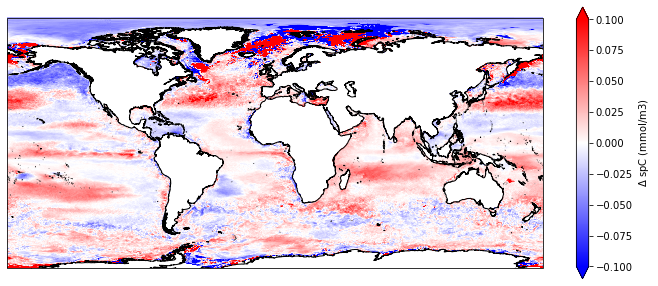

In [15]:
fig = plt.figure(figsize=(12,5))


#----------
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

lon, lat, field = utils.adjust_pop_grid(ds_grid.TLONG.values, ds_grid.TLAT.values, ds_lastpart.spC - ds_firstpart.spC)
ax.coastlines('10m',linewidth=1,zorder=1)
pc=ax.pcolormesh(lon, lat, field,
                 vmin=-0.1, vmax=0.1, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='${\Delta}$ spC (mmol/m3)');

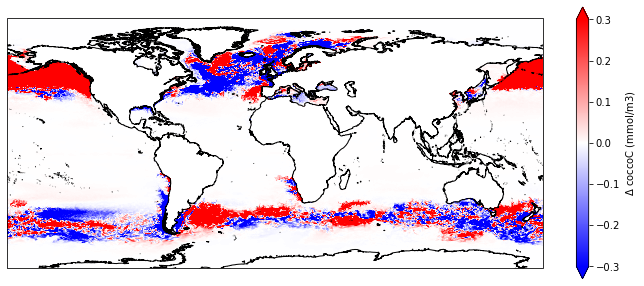

In [17]:
fig = plt.figure(figsize=(12,5))


#----------
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

lon, lat, field = utils.adjust_pop_grid(ds_grid.TLONG.values, ds_grid.TLAT.values, ds_lastpart.coccoC - ds_firstpart.coccoC)
ax.coastlines('10m',linewidth=1,zorder=1)
pc=ax.pcolormesh(lon, lat, field,
                 vmin=-0.3, vmax=0.3, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='${\Delta}$ coccoC (mmol/m3)');

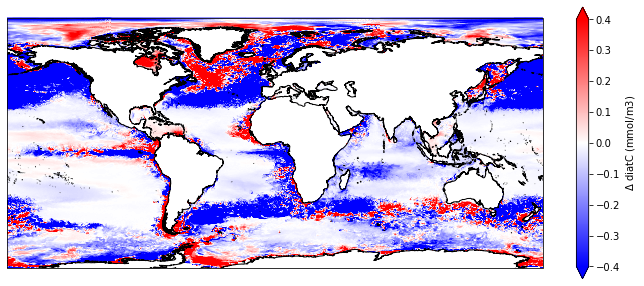

In [19]:
fig = plt.figure(figsize=(12,5))


#----------
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

lon, lat, field = utils.adjust_pop_grid(ds_grid.TLONG.values, ds_grid.TLAT.values, ds_lastpart.diatC - ds_firstpart.diatC)
ax.coastlines('10m',linewidth=1,zorder=1)
pc=ax.pcolormesh(lon, lat, field,
                 vmin=-0.4, vmax=0.4, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='${\Delta}$ diatC (mmol/m3)');

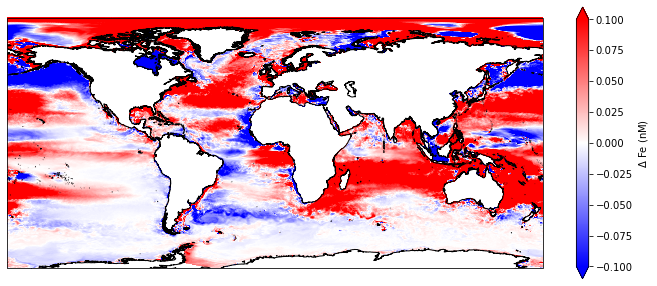

In [20]:
fig = plt.figure(figsize=(12,5))


#----------
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

lon, lat, field = utils.adjust_pop_grid(ds_grid.TLONG.values, ds_grid.TLAT.values, (ds_lastpart.Fe - ds_firstpart.Fe) * 1000.)
ax.coastlines('10m',linewidth=1,zorder=1)
pc=ax.pcolormesh(lon, lat, field,
                 vmin=-0.1, vmax=0.1, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='${\Delta}$ Fe (nM)');

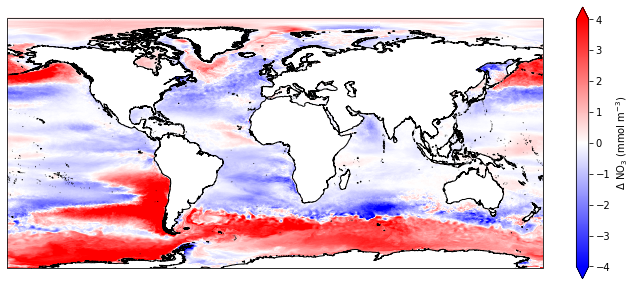

In [23]:
fig = plt.figure(figsize=(12,5))


#----------
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

lon, lat, field = utils.adjust_pop_grid(ds_grid.TLONG.values, ds_grid.TLAT.values, (ds_lastpart.NO3 - ds_firstpart.NO3))
ax.coastlines('10m',linewidth=1,zorder=1)
pc=ax.pcolormesh(lon, lat, field,
                 vmin=-4, vmax=4, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='${\Delta}$ NO$_3$ (mmol m$^{-3}$)');

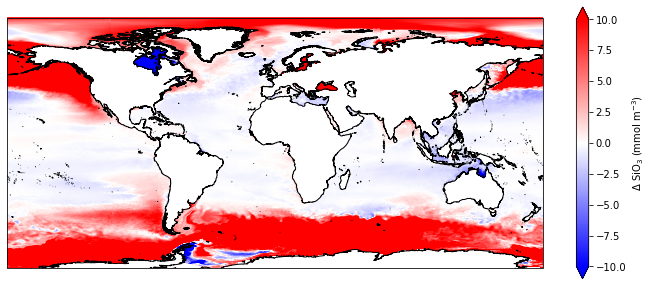

In [26]:
fig = plt.figure(figsize=(12,5))


#----------
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

lon, lat, field = utils.adjust_pop_grid(ds_grid.TLONG.values, ds_grid.TLAT.values, (ds_lastpart.SiO3 - ds_firstpart.SiO3))
ax.coastlines('10m',linewidth=1,zorder=1)
pc=ax.pcolormesh(lon, lat, field,
                 vmin=-10, vmax=10, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='${\Delta}$ SiO$_3$ (mmol m$^{-3}$)');